## Setup

In [13]:
from openai import OpenAI
import pandas as pd
from tqdm import tqdm
import csv
import json
from time import sleep
import os
import matplotlib.pyplot as plt

In [2]:
keys = json.load(open("keys.json"))
DEEPINFRA_API_KEY = keys["DEEPINFRA_API_KEY"]

In [3]:
openai = OpenAI(
    api_key=DEEPINFRA_API_KEY,
    base_url="https://api.deepinfra.com/v1/openai",
)

In [4]:
def generate_response(
    model,
    prompt,
    system_prompt="You're a helpful assistant",
    suffix_prompt='',
    model_config=None
):
    """
    Returns the response from the model

    Args:
        model (str): Model name
        prompt (str): prompt text
        system_prompt (str): System prompt
        suffix_prompt (str): Suffix prompt to append to the prompt
        model_config (dict): Model parameters
    Returns:
        response_text (str): Response text from the model
        final_answer (str): Final numerical answer
    """
    chat_completion = openai.chat.completions.create(
        model=model,
        messages=[
            { "role": "system", "content": system_prompt },
            { "role": "user", "content": prompt + suffix_prompt },
        ],
        **model_config
    )
    response_text = chat_completion.choices[0].message.content
    final_answer = response_text.split("#### ")[-1].strip()

    try:
        cleaned_answer = final_answer.replace(",", "")  # remove commas
        cleaned_answer = cleaned_answer.replace("$", "")    # remove dollar signs
        final_answer = float(cleaned_answer)
    except Exception:
        pass

    return (response_text, final_answer)

In [ ]:
def save_results(filepath, results, model, model_config, system_prompt, suffix_prompt):
    # Add config details to results
    results_with_config = {}
    results_with_config["config"] = {
        "model": model,
        "model_config": model_config,
        "prompt_config": {
            "system_prompt": system_prompt,
            "suffix_prompt": suffix_prompt
        }
    }
    results_with_config["results"] = results

    with open(filepath, "w") as fd:
        json.dump(results_with_config, fd, indent=4)

    print(f"Results saved to {filepath}")

## Sample Inference

In [6]:
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"
system_prompt = "You are a helpful assistant. Do not use or generate code in your responses."

In [7]:
question = "What is 546588 + 493181?"
suffix_prompt = "\n Also append the final numerical answer on a new line append with '#### '"

In [8]:
chat_completion = openai.chat.completions.create(
    model=model,
    messages=[
        { "role": "system", "content": system_prompt },
        { "role": "user", "content": question + suffix_prompt },
    ]
)

In [9]:
print(chat_completion.choices[0].message.content)

To find the sum, I'll add the two numbers:

546588 + 493181 = 1039769

#### 1039769


In [10]:
model_config = {
    "max_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "max_completion_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "stream": False,            # whether to stream the output via SSE or return the full response
    "temperature": 0.7,         # sampling temperature to use, between 0 and 2
    "top_p": 0.9,               # considers the results of the tokens with top_p probability mass
    "n": 1,                     # number of sequences to generate
    "presence_penalty": 0.0,    # penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
    "frequency_penalty": 0.0,   # penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim
    "tools": [],                # A list of tools the model may call. Currently, only functions are supported as a tool.
    "tool_choice": None,        # None: no function call, auto: model can pick between generating a message or calling a function
    "seed": 0
}

In [11]:
def generate_response(
    model,
    prompt,
    system_prompt="You're a helpful assistant",
    suffix_prompt='',
    model_config=None
):
    """
    Returns the response from the model

    Args:
        model (str): Model name
        prompt (str): prompt text
        system_prompt (str): System prompt
        suffix_prompt (str): Suffix prompt to append to the prompt
        model_config (dict): Model parameters
    Returns:
        response_text (str): Response text from the model
        final_answer (str): Final numerical answer
    """
    chat_completion = openai.chat.completions.create(
        model=model,
        messages=[
            { "role": "system", "content": system_prompt },
            { "role": "user", "content": prompt + suffix_prompt },
        ],
        **model_config
    )
    response_text = chat_completion.choices[0].message.content
    final_answer = response_text.split("#### ")[-1].strip()

    try:
        cleaned_answer = final_answer.replace(",", "")  # remove commas
        cleaned_answer = cleaned_answer.replace("$", "")    # remove dollar signs
        final_answer = float(cleaned_answer)
    except Exception:
        pass

    return (response_text, final_answer)

In [12]:
response_text, final_answer = generate_response(model, question, system_prompt=system_prompt, suffix_prompt=suffix_prompt, model_config=model_config)
print(f"response_text: {response_text}")
print(f"final_answer: {final_answer}")

response_text: To calculate the sum, I'll add the two numbers:

546,588 + 493,181 = 1,039,769

#### 1,039,769
final_answer: 1039769.0


## Arithmetic Length Generalization Dataset (ALGD) Inference

In [15]:
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"
system_prompt = "You are a helpful assistant. Do not use or generate code in your responses."
suffix_prompt = "\n Also append the final numerical answer on a new line append with '#### '"

In [16]:
model_config = {
    "max_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "max_completion_tokens": 512,   # max number of completion tokens, including visible output tokens and reasoning tokens
    "stream": False,            # whether to stream the output via SSE or return the full response
    "temperature": 0.7,         # sampling temperature to use, between 0 and 2
    "top_p": 0.9,               # considers the results of the tokens with top_p probability mass
    "n": 1,                     # number of sequences to generate
    "presence_penalty": 0.0,    # penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
    "frequency_penalty": 0.0,   # penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim
    "tools": [],                # A list of tools the model may call. Currently, only functions are supported as a tool.
    "tool_choice": None,        # None: no function call, auto: model can pick between generating a message or calling a function
    "seed": 0
}

In [ ]:
def evaluate_file(file_path):
    # Load CSV file into a DataFrame
    data = pd.read_csv(file_path)

    # Assuming the file has "Question" and "Answer" columns
    correct_count = 0
    results = []

    for _, row in tqdm(data.iterrows(), total=len(data)):
        question = row["Question"]
        correct_answer = row["Answer"]

        # convert to float
        correct_answer = float(correct_answer)

        # Get GPT-4's answer
        response_text, predicted_final_answer = generate_response(
            model,
            question,
            system_prompt=system_prompt,
            suffix_prompt=suffix_prompt,
            model_config=model_config
        )

        # Evaluate correctness
        is_correct = predicted_final_answer == correct_answer

        if is_correct:
            correct_count += 1

        # Append result
        results.append({
            "Question": question,
            "Response Text": response_text,
            "Predicted Answer": predicted_final_answer,
            "Correct Answer": correct_answer,
            "Is Correct": is_correct
        })

        sleep(1)    # sleep to avoid rate limiting

    # Calculate accuracy
    total_questions = len(data)
    accuracy = (correct_count / total_questions) * 100
    print(f"Accuracy for {file_path.split('/')[-1]}: {accuracy:.2f}%")

    # Save results for this file
    output_file = file_path.replace(".csv", "_evaluation_results.csv")
    with open(output_file, "w", newline="") as csvfile:
        fieldnames = ["Question", "Response Text", "Predicted Answer", "Correct Answer", "Is Correct"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)

    print(f"Results for {file_path} saved to {output_file}")

### Addition

In [ ]:
file_paths = [
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/1-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/2-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/3-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/4-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/5-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/6-d-add.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/7-d-add.csv'
]

In [35]:
for file_path in file_paths:
    evaluate_file(file_path)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Accuracy for 2-d-add.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/2-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/2-d-add_evaluation_results.csv


100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


Accuracy for 3-d-add.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/3-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/3-d-add_evaluation_results.csv


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


Accuracy for 4-d-add.csv: 96.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/4-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/4-d-add_evaluation_results.csv


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


Accuracy for 5-d-add.csv: 98.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/5-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/5-d-add_evaluation_results.csv


100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Accuracy for 6-d-add.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/6-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/6-d-add_evaluation_results.csv


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]

Accuracy for 7-d-add.csv: 92.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/7-d-add.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/add/7-d-add_evaluation_results.csv


### Multiplication

In [36]:
file_paths = [
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/1-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/2-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/3-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/4-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/5-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/6-d-MUL.csv',
    '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/7-d-MUL.csv'
]

In [37]:
for file_path in file_paths:
    evaluate_file(file_path)

100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


Accuracy for 1-d-MUL.csv: 100.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/1-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/1-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:45<00:00,  2.25s/it]


Accuracy for 2-d-MUL.csv: 96.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/2-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/2-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


Accuracy for 3-d-MUL.csv: 44.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/3-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/3-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


Accuracy for 4-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/4-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/4-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


Accuracy for 5-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/5-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/5-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


Accuracy for 6-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/6-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/6-d-MUL_evaluation_results.csv


100%|██████████| 100/100 [04:21<00:00,  2.62s/it]

Accuracy for 7-d-MUL.csv: 0.00%
Results for /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/7-d-MUL.csv saved to /Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/multiply/7-d-MUL_evaluation_results.csv


### Digit Match plots

In [ ]:
df = pd.read_csv('/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-70B/multiply/7-d-MUL_evaluation_results.csv')

# Function to compare digits up to the length of the shorter number
def compare_digits(predicted, correct):
    predicted_str = str(int(predicted))
    correct_str = str(int(correct))
    min_len = min(len(predicted_str), len(correct_str))

    # Compare digits up to the length of the shorter number
    digit_matches = [predicted_str[i] == correct_str[i] for i in range(min_len)]
    return digit_matches

# Apply the function and create new columns
for index, row in df.iterrows():
    digit_matches = compare_digits(row['Predicted Answer'], row['Correct Answer'])
    for i, match in enumerate(digit_matches):
        column_name = f'Digit_{i+1}_Match'
        df.at[index, column_name] = match

# Save the updated DataFrame to a new CSV file
df.to_csv('llama-3.1-70b-Instruct-7d-mul_digit_matches.csv', index=False)

In [9]:
results_csv = '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gpt-4o-mini/Multiplication/7-d-MUL_evaluation_results.csv'
df = pd.read_csv(results_csv)

# Function to compare digits up to the length of the shorter number
def compare_digits(predicted, correct):
    predicted_str = str(int(predicted))
    correct_str = str(int(correct))
    min_len = min(len(predicted_str), len(correct_str))

    # Compare digits up to the length of the shorter number
    digit_matches = [predicted_str[i] == correct_str[i] for i in range(min_len)]
    return digit_matches

# Apply the function and create new columns
for index, row in df.iterrows():
    digit_matches = compare_digits(row['GPT-4 Answer'], row['Correct Answer'])
    for i, match in enumerate(digit_matches):
        column_name = f'Digit_{i+1}_Match'
        df.at[index, column_name] = match

# Save the updated DataFrame to a new CSV file
outfile = os.path.join(os.path.dirname(results_csv), 'gpt-4o-mini-7d-mul-digit_matches.csv')
df.to_csv(outfile, index=False)

In [6]:
df.head()

,Question,Response Text,Predicted Answer,Correct Answer,Is Correct,Digit_1_Match,Digit_2_Match,Digit_3_Match,Digit_4_Match,Digit_5_Match,Digit_6_Match,Digit_7_Match,Digit_8_Match,Digit_9_Match,Digit_10_Match,Digit_11_Match,Digit_12_Match,Digit_13_Match,Digit_14_Match
0,What is 2838170 * 4070561?,To calculate the product of 2838170 and 407056...,1.153611e+12,1.155294e+13,False,True,True,True,False,False,False,False,False,True,False,False,False,False,NaN
1,What is 4597376 * 1651837?,"To calculate the result of 4597376 * 1651837, ...",7.585111e+14,7.594116e+12,False,True,True,False,False,True,True,False,False,False,False,False,True,False,NaN
2,What is 8007515 * 9097425?,To calculate the product of 8007515 and 909742...,7.284119e+13,7.284777e+13,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True
3,What is 3555133 * 5135796?,To calculate the product of 3555133 and 513579...,1.824132e+13,1.825844e+13,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True
4,What is 7537796 * 2387296?,"To calculate this, I'll multiply the two numbe...",1.800111e+13,1.799495e+13,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True


In [9]:
import matplotlib.pyplot as plt

/var/folders/1t/_gfb7gs50xsg4bxb5zmygxk00000gn/T/ipykernel_48582/2560971349.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_matches[digit_match_columns] = df_matches[digit_match_columns].fillna(False)


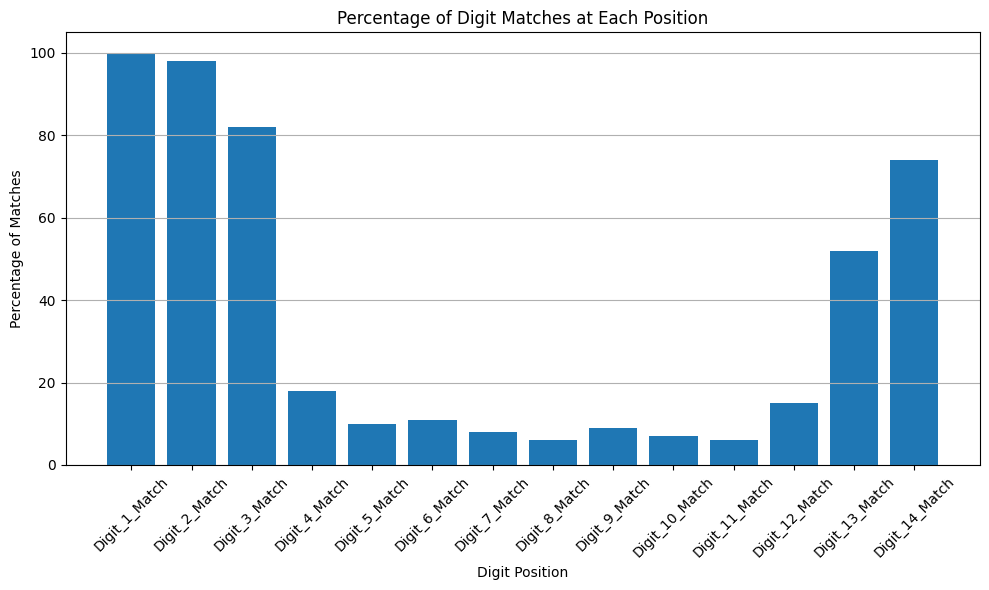

In [10]:
df_matches = df.copy()  # create a copy

# Extract digit match columns
digit_match_columns = [col for col in df_matches.columns if col.startswith('Digit_')]

# Fill NaN values with False
df_matches[digit_match_columns] = df_matches[digit_match_columns].fillna(False)

# Calculate the percentage of matches for each digit position
digit_match_percentages = df_matches[digit_match_columns].mean() * 100

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(digit_match_percentages.index, digit_match_percentages.values)
plt.xlabel('Digit Position')
plt.ylabel('Percentage of Matches')
plt.title('Percentage of Digit Matches at Each Position')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

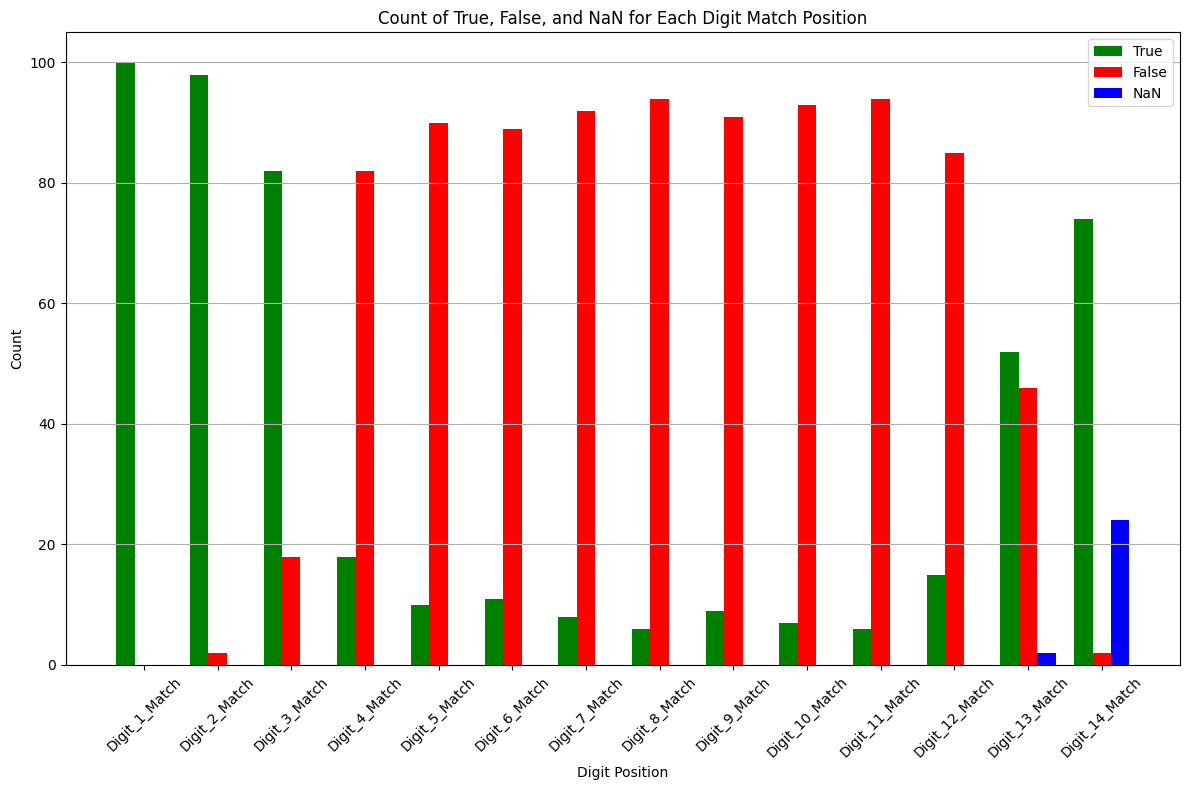

In [13]:
df_matches = df.copy()  # create a copy

# Extract digit match columns
digit_match_columns = [col for col in df_matches.columns if col.startswith('Digit_')]

true_counts = {}
false_counts = {}
nan_counts = {}

# Count True, False, and NaN values for each digit match column
for col in digit_match_columns:
    true_counts[col] = df_matches[col].sum()
    false_counts[col] = df_matches[col].count() - df_matches[col].sum()
    nan_counts[col] = df_matches[col].isna().sum()

# Plot the data
x = range(len(digit_match_columns))
width = 0.25  # width of the bars

plt.figure(figsize=(12, 8))
plt.bar(x, [true_counts[col] for col in digit_match_columns], width=width, label='True', color='g')
plt.bar([p + width for p in x], [false_counts[col] for col in digit_match_columns], width=width, label='False', color='r')
plt.bar([p + width*2 for p in x], [nan_counts[col] for col in digit_match_columns], width=width, label='NaN', color='b')

plt.xlabel('Digit Position')
plt.ylabel('Count')
plt.title('Count of True, False, and NaN for Each Digit Match Position')
plt.xticks([p + width for p in x], digit_match_columns, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

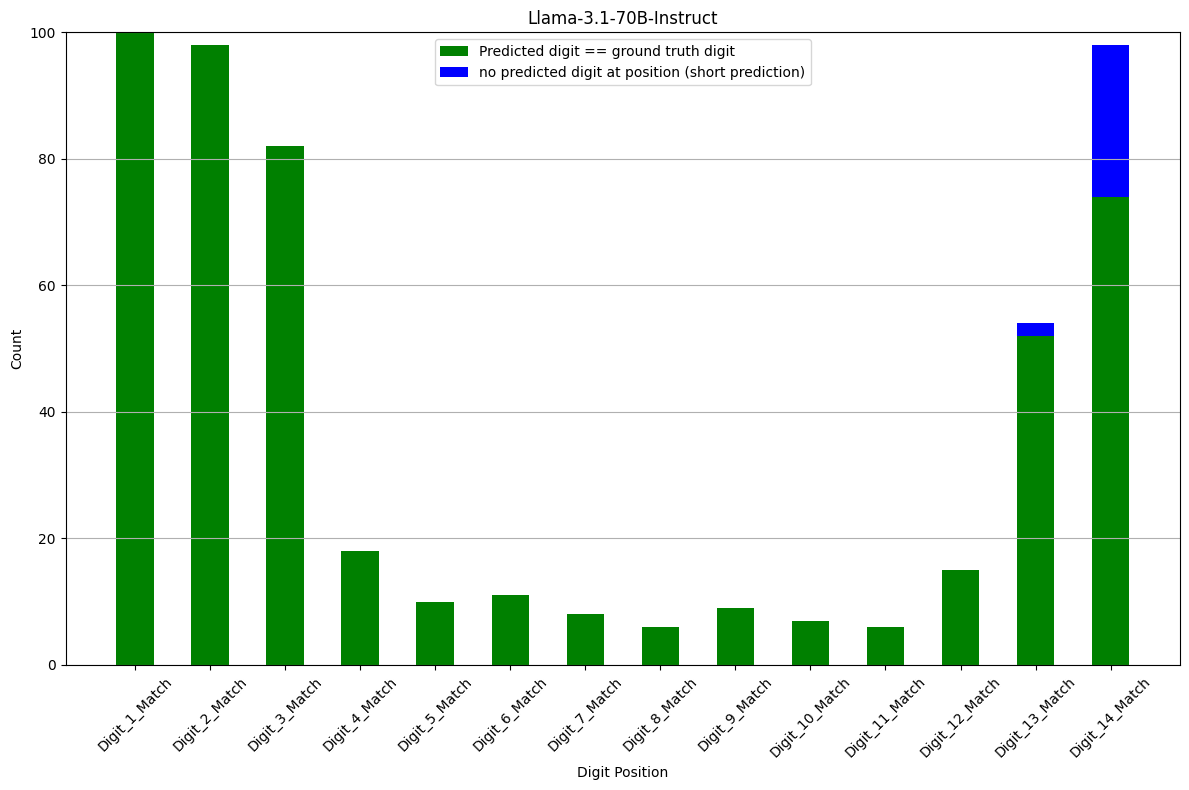

In [14]:
results_csv = '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/llama-3.1-70b/multiply/llama-3.1-70b-Instruct-7d-mul_digit_matches.csv'

df = pd.read_csv(results_csv)
df_matches = df.copy()  # create a copy

# Extract digit match columns
digit_match_columns = [col for col in df_matches.columns if col.startswith('Digit_')]

# Initialize dictionaries to store counts
true_counts = {}
false_counts = {}
nan_counts = {}

# Count True, False, and NaN values for each digit match column
for col in digit_match_columns:
    true_counts[col] = df_matches[col].sum()
    false_counts[col] = df_matches[col].count() - df_matches[col].sum()
    nan_counts[col] = df_matches[col].isna().sum()

# Plot the data
x = range(len(digit_match_columns))
width = 0.5  # width of the bars

plt.figure(figsize=(12, 8))
# plt.bar(x, [true_counts[col] for col in digit_match_columns], label='True', color='g', width=width)
# plt.bar(x, [false_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='False', color='r', width=width)
# plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] + false_counts[col] for col in digit_match_columns], label='NaN', color='b', width=width)

plt.bar(x, [true_counts[col] for col in digit_match_columns], label='Predicted digit == ground truth digit', color='g', width=width)
plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='no predicted digit at position (short prediction)', color='b', width=width)

plt.xlabel('Digit Position')
plt.ylabel('Count')
# plt.title('% of matches for each digit position')
plt.title('Llama-3.1-70B-Instruct')
plt.xticks(x, digit_match_columns, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

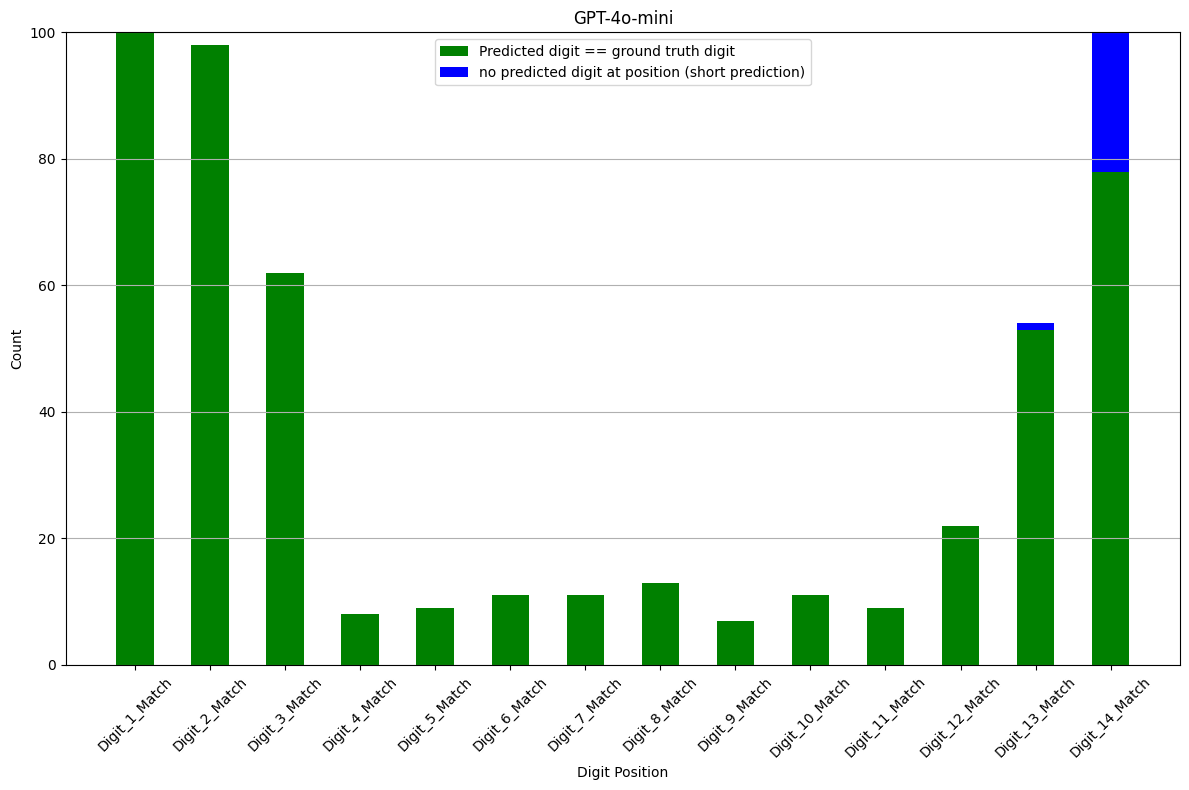

In [15]:
results_csv = '/Users/ashish/Documents/academic/fall24/nlp/project/arithmetic-ood/algd/gpt-4o-mini/Multiplication/gpt-4o-mini-7d-mul-digit_matches.csv'

df = pd.read_csv(results_csv)
df_matches = df.copy()  # create a copy

# Extract digit match columns
digit_match_columns = [col for col in df_matches.columns if col.startswith('Digit_')]

# Initialize dictionaries to store counts
true_counts = {}
false_counts = {}
nan_counts = {}

# Count True, False, and NaN values for each digit match column
for col in digit_match_columns:
    true_counts[col] = df_matches[col].sum()
    false_counts[col] = df_matches[col].count() - df_matches[col].sum()
    nan_counts[col] = df_matches[col].isna().sum()

# Plot the data
x = range(len(digit_match_columns))
width = 0.5  # width of the bars

plt.figure(figsize=(12, 8))
# plt.bar(x, [true_counts[col] for col in digit_match_columns], label='True', color='g', width=width)
# plt.bar(x, [false_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='False', color='r', width=width)
# plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] + false_counts[col] for col in digit_match_columns], label='NaN', color='b', width=width)

plt.bar(x, [true_counts[col] for col in digit_match_columns], label='Predicted digit == ground truth digit', color='g', width=width)
plt.bar(x, [nan_counts[col] for col in digit_match_columns], bottom=[true_counts[col] for col in digit_match_columns], label='no predicted digit at position (short prediction)', color='b', width=width)

plt.xlabel('Digit Position')
plt.ylabel('Count')
# plt.title('% of matches for each digit position')
plt.title('GPT-4o-mini')
plt.xticks(x, digit_match_columns, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()